In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [4]:
data = pd.read_csv("../NullValueHandled/jaffnaHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000058
2019-01-02,2019-01-03,0.000102
2019-01-03,2019-01-04,0.000039
2019-01-04,2019-01-05,-0.000002
2019-01-05,2019-01-06,0.000159


In [7]:
jaffna_data = data[["HCHO reading"]]
jaffna_data.head()  

,HCHO reading
Current Date,
2019-01-01,0.000058
2019-01-02,0.000102
2019-01-03,0.000039
2019-01-04,-0.000002
2019-01-05,0.000159


In [8]:
jaffna_data.shape 

(1826, 1)

In [9]:
X = jaffna_data.values 

#### This looks like that Jaffna fomaldihyde rates have a small seasonality

<Axes: xlabel='Current Date'>

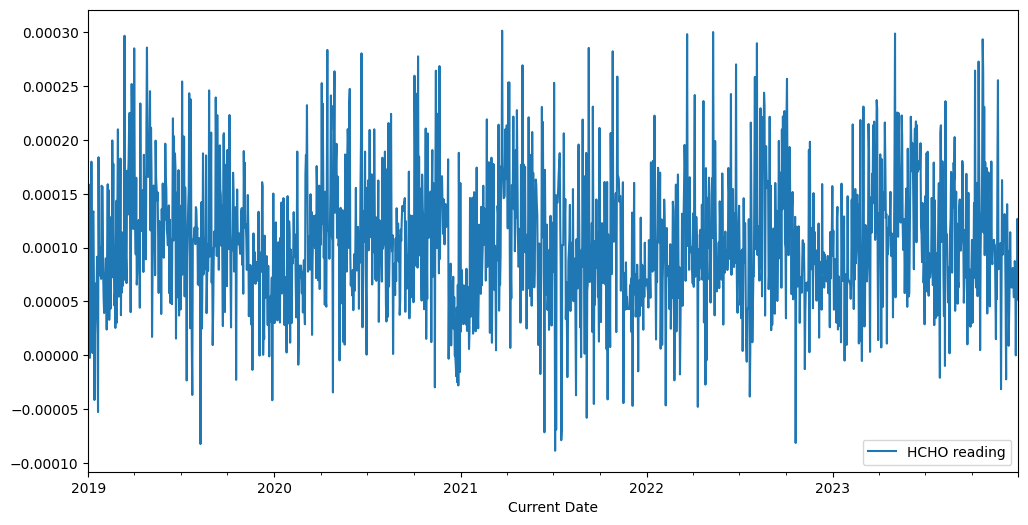

In [15]:
jaffna_data.plot(figsize=(12, 6)) 

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
test_jaffna = adfuller(jaffna_data["HCHO reading"], autolag="AIC") 

In [18]:
print("ADF value : ", test_jaffna[0])
print("P value: ", test_jaffna[1])
print("Num of Lags :", test_jaffna[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_jaffna[3])
for key, val in test_jaffna[4].items():
    print("\t", key, ": ", val)

ADF value :  -7.500971660167281
P value:  4.254622130663339e-11
Num of Lags : 11
Num of Observations used for ADF Regression and Critical Calculation : 1814
	 1% :  -3.4339600207952796
	 5% :  -2.863134623063046
	 10% :  -2.5676189242070433


#### Auto correlation and correlation plot for Jaffna

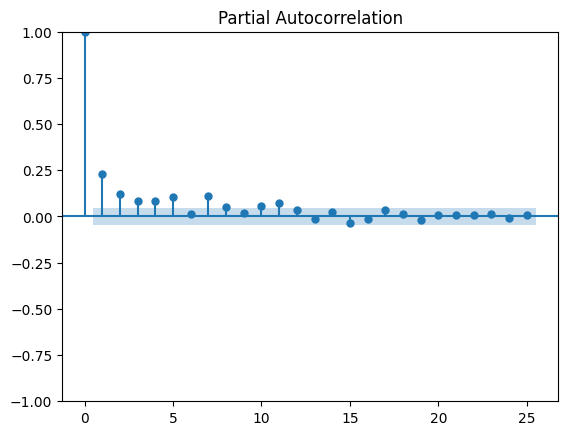

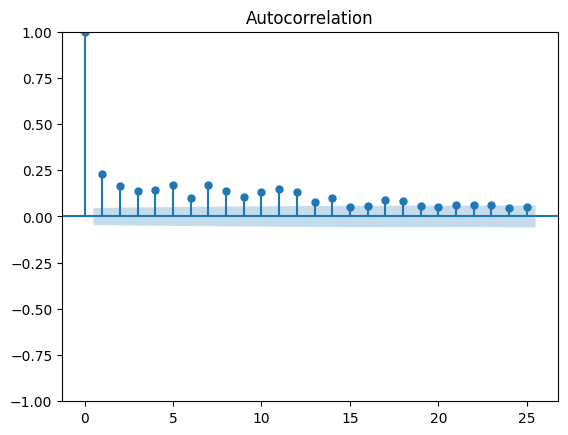

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(jaffna_data["HCHO reading"], lags=25)
acf = plot_acf(jaffna_data["HCHO reading"], lags=25)  

#### There is a small stationarity and seasonality in Jaffna data

#### Jaffna LSTM

In [37]:
data = pd.read_csv("../NullValueHandled/jaffnaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [38]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000058
1   2019-01-02      0.000102
2   2019-01-03      0.000039
3   2019-01-04     -0.000002
4   2019-01-05      0.000159


In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 102s 1s/step - loss: 1.0603 - mean_squared_error: 1.0603 - val_loss: 0.9062 - val_mean_squared_error: 0.9062
Epoch 2/100
37/37 [==============================] - 26s 714ms/step - loss: 1.0055 - mean_squared_error: 1.0055 - val_loss: 0.9252 - val_mean_squared_error: 0.9252
Epoch 3/100
37/37 [==============================] - 15s 413ms/step - loss: 0.9956 - mean_squared_error: 0.9956 - val_loss: 1.0247 - val_mean_squared_error: 1.0247
Epoch 4/100
37/37 [==============================] - 15s 402ms/step - loss: 0.9744 - mean_squared_error: 0.9744 - val_loss: 0.9128 - val_mean_squared_error: 0.9128
Epoch 5/100
37/37 [==============================] - 14s 382ms/step - loss: 0.9726 - mean_squared_error: 0.9726 - val_loss: 1.0043 - val_mean_squared_error: 1.0043
Epoch 6/100
37/37 [==============================] - 14s 380ms/step - loss: 0.9611 - mean_squared_error: 0.9611 - val_loss: 0.8954 - val_mean_squared_error: 0.8954
Epoch 7/100
37/37 

Epoch 51/100
37/37 [==============================] - 17s 459ms/step - loss: 0.8252 - mean_squared_error: 0.8252 - val_loss: 1.0387 - val_mean_squared_error: 1.0387
Epoch 52/100
37/37 [==============================] - 18s 496ms/step - loss: 0.8112 - mean_squared_error: 0.8112 - val_loss: 1.1926 - val_mean_squared_error: 1.1926
Epoch 53/100
37/37 [==============================] - 16s 436ms/step - loss: 0.8610 - mean_squared_error: 0.8610 - val_loss: 0.9164 - val_mean_squared_error: 0.9164
Epoch 54/100
37/37 [==============================] - 15s 417ms/step - loss: 0.8026 - mean_squared_error: 0.8026 - val_loss: 0.9499 - val_mean_squared_error: 0.9499
Epoch 55/100
37/37 [==============================] - 14s 371ms/step - loss: 0.8171 - mean_squared_error: 0.8171 - val_loss: 0.9982 - val_mean_squared_error: 0.9982
Epoch 56/100
37/37 [==============================] - 13s 355ms/step - loss: 0.8109 - mean_squared_error: 0.8109 - val_loss: 0.9740 - val_mean_squared_error: 0.9740
Epoch 57/1

12/12 [==============================] - 15s 107ms/step


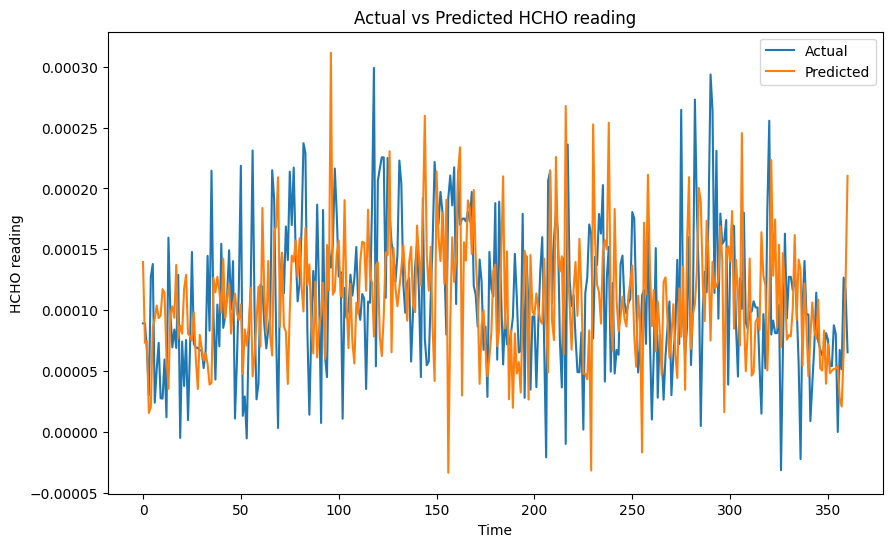

In [40]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 6s 123ms/step


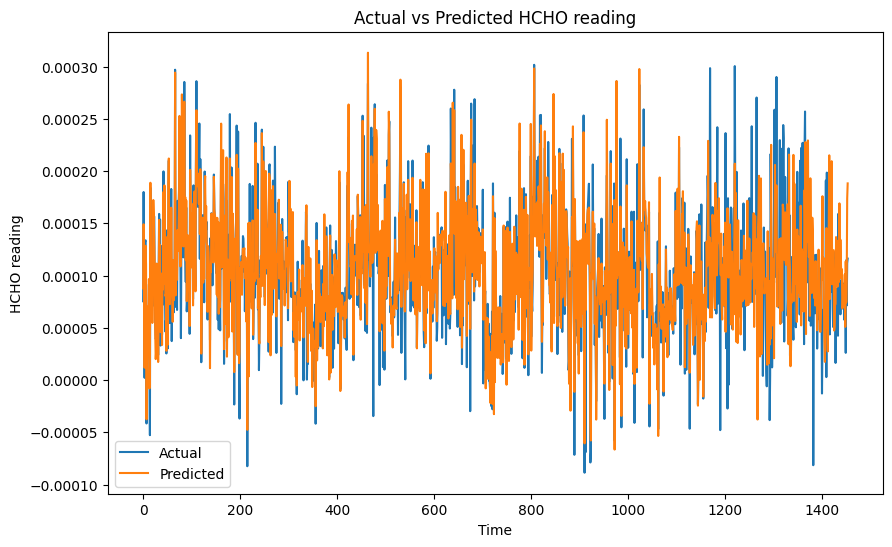

In [41]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 5s 98ms/step


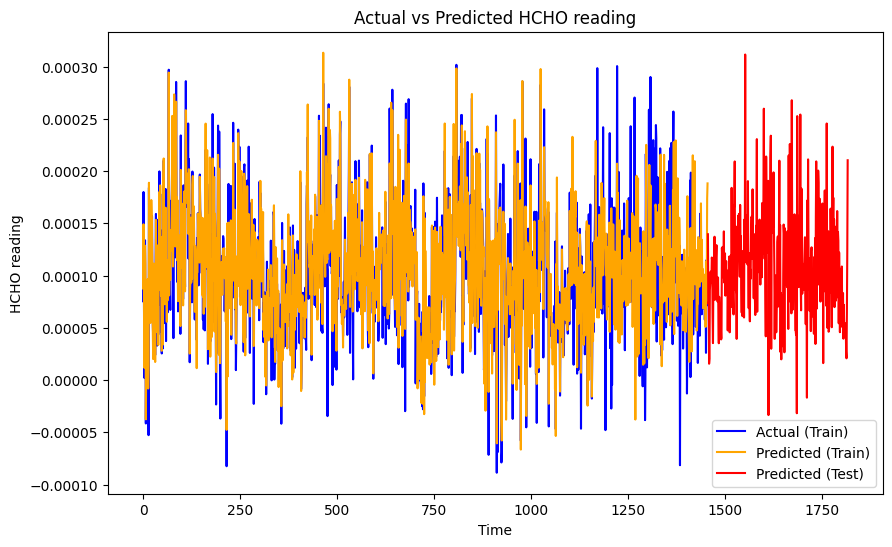

In [42]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [43]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6245367469069611
Mean Absolute Error (MAE): 2.356567771214922e-05
Mean Squared Error (MSE): 1.3467486626867525e-09
Root Mean Squared Error (RMSE): 3.6698074373006993e-05
Median Absolute Error: 1.5085225960387793e-05
Explained Variance Score: 0.625571765968431


09:37:24 - cmdstanpy - INFO - Chain [1] start processing
09:37:24 - cmdstanpy - INFO - Chain [1] done processing


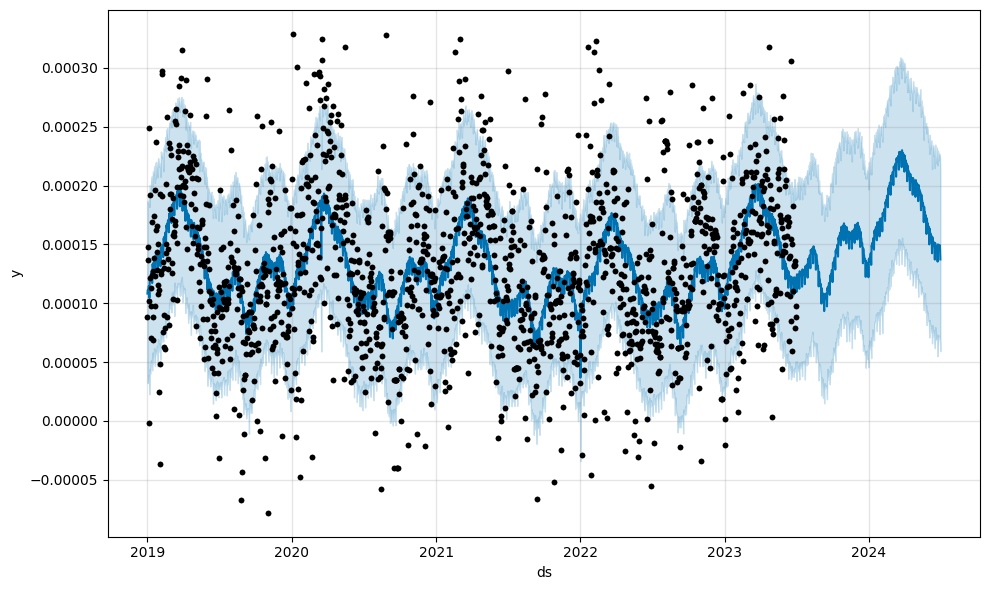

In [45]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,
               changepoint_prior_scale=0.2, 
               seasonality_prior_scale=5,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

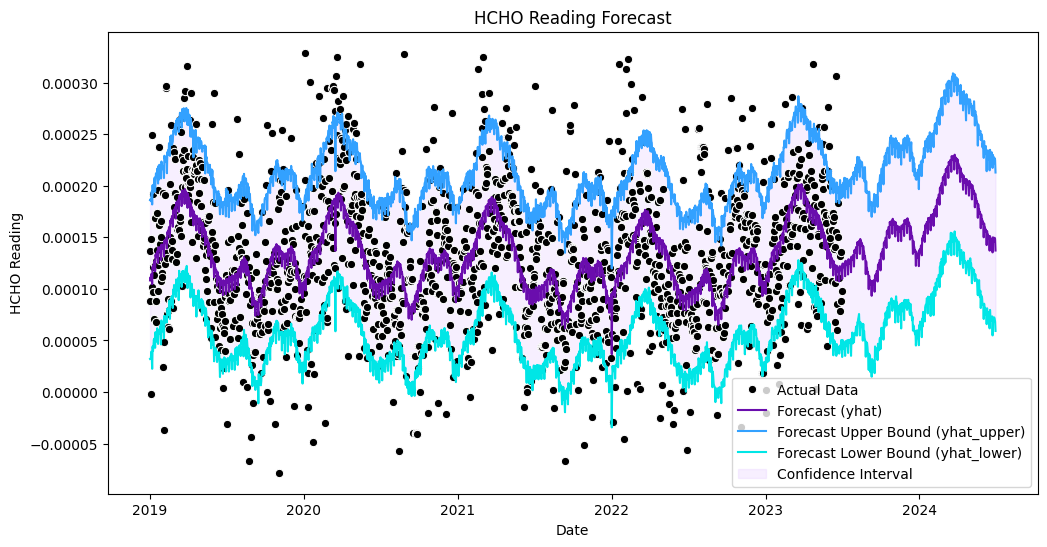

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

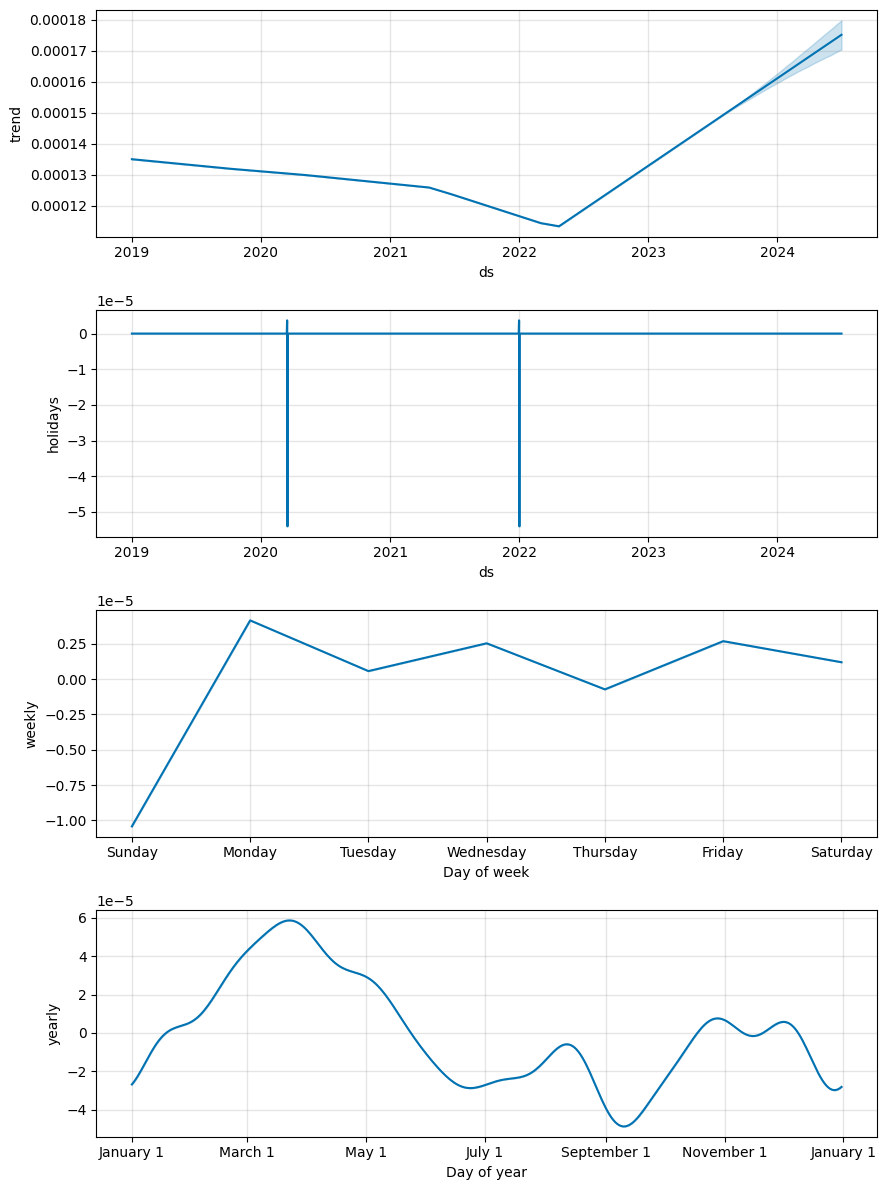

In [47]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [48]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.24090460356226395
Mean Absolute Error (MAE): 5.1367706162723475e-05
Mean Squared Error (MSE): 4.20306978271274e-09
Root Mean Squared Error (RMSE): 6.483108654582877e-05
Median Absolute Error: 4.6628677122368715e-05
Explained Variance Score: 0.07082367879966855


#### Jaffna Multi Variate Model

In [178]:
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   int64  
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   int64  
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [180]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [181]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000058,Jaffna Proper,9.66,80.0,5,0.00,77.162,79.556,75.056,617000,1025,601.95,0,0.037301,0.000009,0.117317,0,0,Before,Before
1,2019-01-02,0.000102,Jaffna Proper,9.66,80.0,5,0.00,77.126,79.790,74.570,617000,1025,601.95,0,0.036426,0.000015,0.117317,0,0,Before,Before
2,2019-01-03,0.000039,Jaffna Proper,9.66,80.0,5,0.00,77.630,80.312,75.398,617000,1025,601.95,0,0.032319,0.000014,0.117317,0,0,Before,Before
3,2019-01-04,-0.000002,Jaffna Proper,9.66,80.0,5,0.00,77.558,80.312,75.110,617000,1025,601.95,0,0.033745,0.000011,0.117317,0,0,Before,Before
4,2019-01-05,0.000159,Jaffna Proper,9.66,80.0,5,0.03,77.990,80.510,75.938,617000,1025,601.95,0,0.033120,0.000009,0.117317,0,0,Before,Before


#### remove constant data

In [182]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [183]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [184]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000058,0.00,77.162,79.556,75.056,617000,601.95,0.037301,0.000009,0.117317,0,0,Before,Before
1,2019-01-02,0.000102,0.00,77.126,79.790,74.570,617000,601.95,0.036426,0.000015,0.117317,0,0,Before,Before
2,2019-01-03,0.000039,0.00,77.630,80.312,75.398,617000,601.95,0.032319,0.000014,0.117317,0,0,Before,Before
3,2019-01-04,-0.000002,0.00,77.558,80.312,75.110,617000,601.95,0.033745,0.000011,0.117317,0,0,Before,Before
4,2019-01-05,0.000159,0.03,77.990,80.510,75.938,617000,601.95,0.033120,0.000009,0.117317,0,0,Before,Before


#### Encode Categorical data

In [185]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [186]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000058,0.00,77.162,79.556,75.056,617000,601.95,0.037301,0.000009,0.117317,0,0,1,1
1,2019-01-02,0.000102,0.00,77.126,79.790,74.570,617000,601.95,0.036426,0.000015,0.117317,0,0,1,1
2,2019-01-03,0.000039,0.00,77.630,80.312,75.398,617000,601.95,0.032319,0.000014,0.117317,0,0,1,1
3,2019-01-04,-0.000002,0.00,77.558,80.312,75.110,617000,601.95,0.033745,0.000011,0.117317,0,0,1,1
4,2019-01-05,0.000159,0.03,77.990,80.510,75.938,617000,601.95,0.033120,0.000009,0.117317,0,0,1,1


#### Check correlations

In [191]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr = corr.T
corr

,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
HCHO reading,1.0,-0.03,0.273649,0.277234,0.231368,-0.023043,-0.023053,0.00484,0.069345,0.204257,-0.085571,-0.019135,0.024783,-0.041622


In [192]:
corr.to_csv("../OtherData/JaffnaCorrelationData.csv")

In [149]:
data.shape

(1826, 15)

#### remove covid lockdown status

In [150]:
data.drop(columns=["lockdown_status"], inplace=True)

#### Devide X and Y

In [151]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [152]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,covid_range_status
0,2019-01-01,0.00,77.162,79.556,75.056,617000,601.95,0.037301,0.000009,0.117317,0,0,1
1,2019-01-02,0.00,77.126,79.790,74.570,617000,601.95,0.036426,0.000015,0.117317,0,0,1
2,2019-01-03,0.00,77.630,80.312,75.398,617000,601.95,0.032319,0.000014,0.117317,0,0,1
3,2019-01-04,0.00,77.558,80.312,75.110,617000,601.95,0.033745,0.000011,0.117317,0,0,1
4,2019-01-05,0.03,77.990,80.510,75.938,617000,601.95,0.033120,0.000009,0.117317,0,0,1


#### Select features based on Correlations

In [153]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.030000
TAVG                    0.273649
TMAX                    0.277234
TMIN                    0.231368
Population             -0.023043
population_density     -0.023053
carbon_monoxide         0.004840
nitogen_dioxide         0.069345
ozone                   0.204257
new_covid_patients     -0.085571
total_covid_patients   -0.019135
covid_range_status     -0.041622
Name: HCHO reading, dtype: float64

In [154]:
X = X[["Current Date", "ozone", "TMAX"]]
X.head() 

,Current Date,ozone,TMAX
0,2019-01-01,0.117317,79.556
1,2019-01-02,0.117317,79.790
2,2019-01-03,0.117317,80.312
3,2019-01-04,0.117317,80.312
4,2019-01-05,0.117317,80.510


In [155]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Current Date  1826 non-null   object 
 1   ozone         1826 non-null   float64
 2   TMAX          1826 non-null   float64
dtypes: float64(2), object(1)
memory usage: 42.9+ KB


#### Standardize, variable data

In [156]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["ozone", "TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [157]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ozone   1826 non-null   float64
 1   TMAX    1826 non-null   float64
dtypes: float64(2)
memory usage: 42.8 KB


##### Standardize target variable

In [158]:
y = data['HCHO reading']

y.head()

0    0.000058
1    0.000102
2    0.000039
3   -0.000002
4    0.000159
Name: HCHO reading, dtype: float64

In [159]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [160]:
X_scaled = X

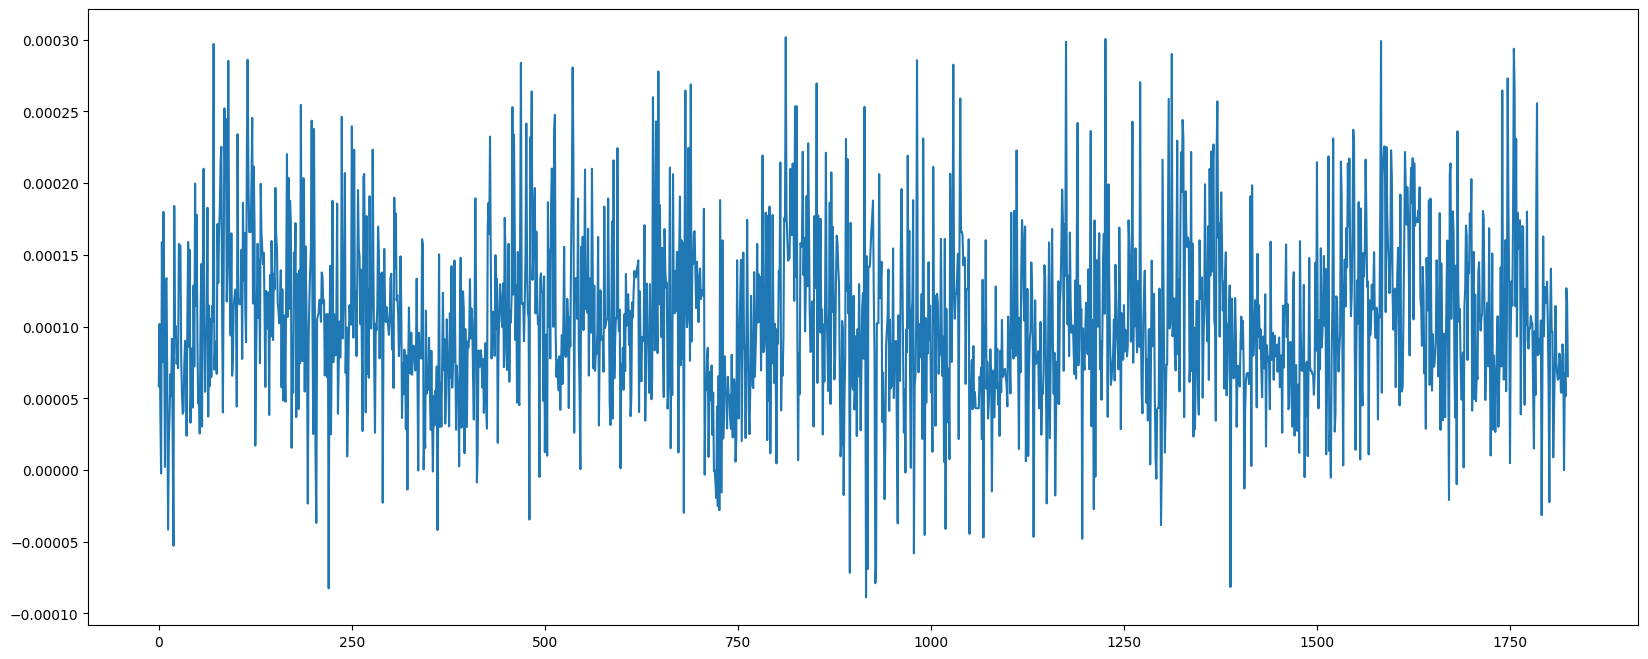

In [161]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [162]:
print(X_scaled.head())

                 ozone      TMAX
Current Date                    
2019-01-01   -0.438401 -2.125805
2019-01-02   -0.438401 -2.042775
2019-01-03   -0.438401 -1.857554
2019-01-04   -0.438401 -1.857554
2019-01-05   -0.438401 -1.787298


#### Apply multivariate time series model

In [194]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = RMSprop(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
46/46 [==============================] - 14s 47ms/step - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 2/150
46/46 [==============================] - 0s 6ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 3/150
46/46 [==============================] - 0s 6ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 4/150
46/46 [==============================] - 0s 5ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 5/150
46/46 [==============================] - 0s 5ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 6/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 7/150
46/46 [=============

46/46 [==============================] - 0s 7ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 52/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 53/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 54/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 55/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 56/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 57/150
46/46 [=====================

46/46 [==============================] - 0s 7ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 102/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 103/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 104/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 105/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 106/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 107/150
46/46 [===============

12/12 [==============================] - 0s 3ms/step - loss: 0.0234 - mean_squared_error: 0.0234
Test Loss: [0.023431595414876938, 0.023431595414876938]
12/12 [==============================] - 2s 1ms/step


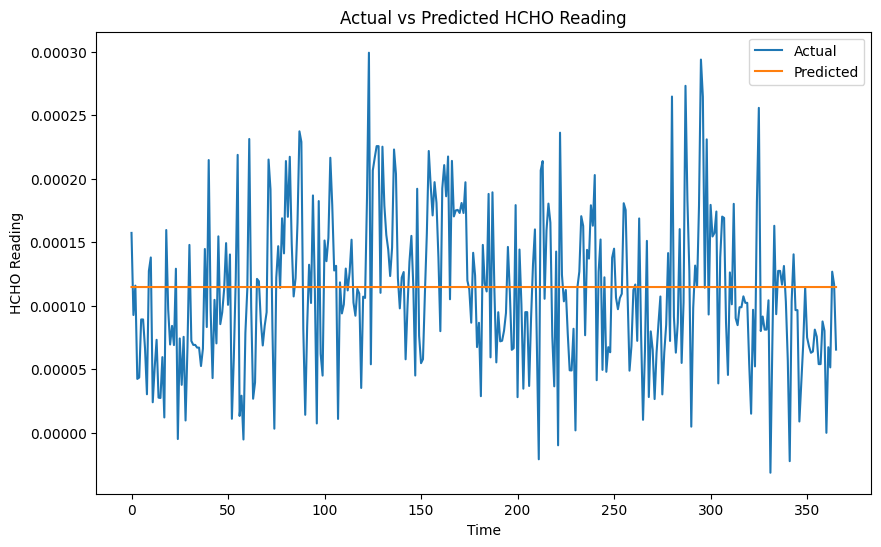

In [195]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 3ms/step


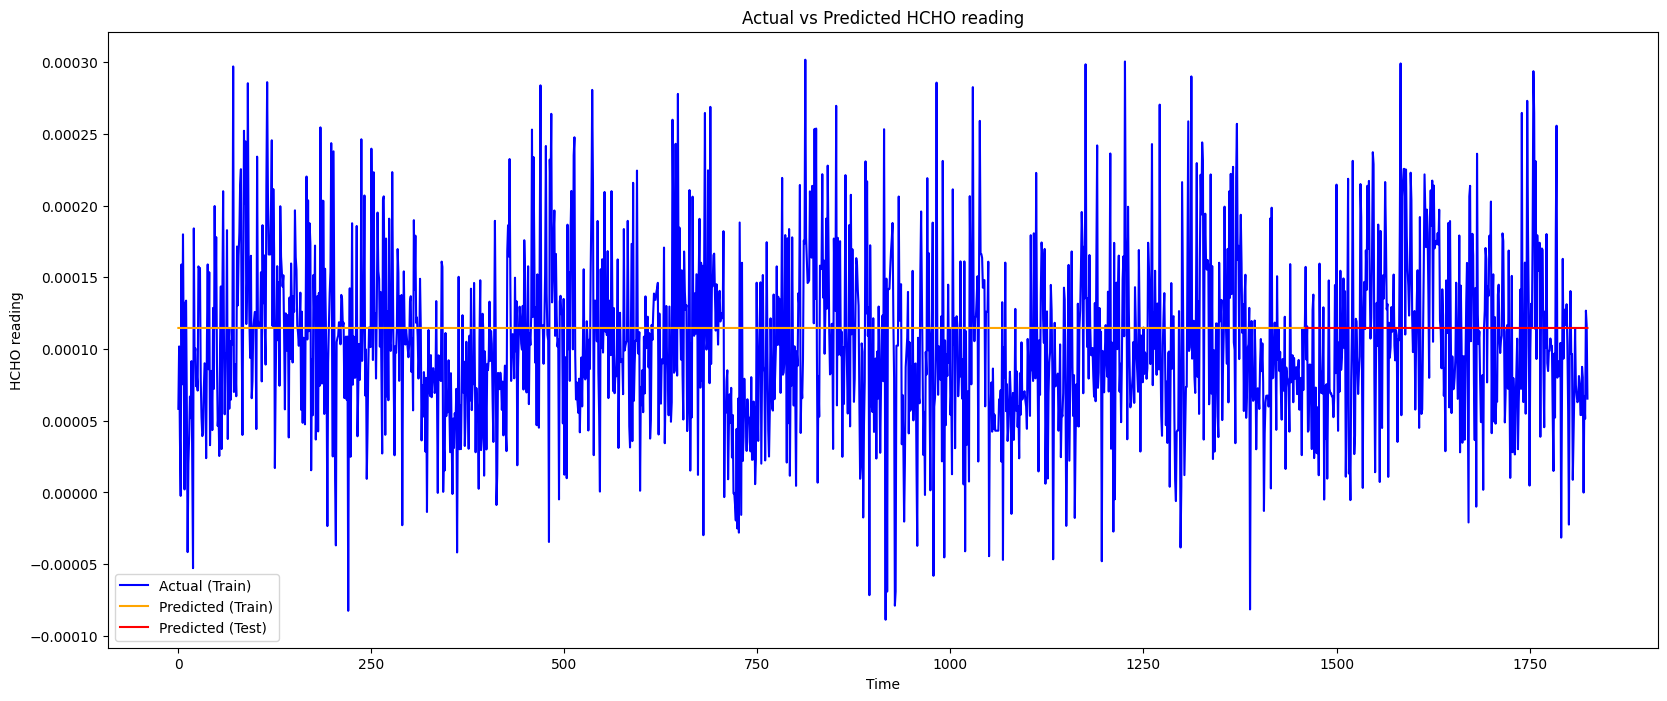

In [196]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [197]:
r2 = (r2_score(actual_test, predictions_test))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.0040996151545262816
Mean Absolute Error (MAE): 4.7881323617664504e-05
Mean Squared Error (MSE): 3.5705309110209446e-09
Root Mean Squared Error (RMSE): 5.9753919628932666e-05
Median Absolute Error: 4.239468072729883e-05
Explained Variance Score: -9.497183268702969e-07
